# Firefly Algorithm for Traveling Salesman Problem (MK)

The Traveling Salesman Problem (TSP) is a well known combinatorial optimization problem in which the goal is to determine the shortest possible route that visits each city exactly once and returns to the starting point. In this study, the problem is formulated using a time based distance matrix, where the travel cost between cities represents travel time rather than geometric distance.

After establishing a baseline solution using Ant Colony Optimization, the objective of this section is to explore the Firefly Algorithm as an alternative metaheuristic and evaluate its performance on the same problem instance. The Firefly Algorithm is inspired by the social flashing behavior of fireflies, where individuals are attracted to others with higher brightness, corresponding to better solutions in the optimization context.

The main goal is to analyze how the Firefly Algorithm behaves on a discrete, permutation based problem such as the TSP, and to investigate whether appropriate adaptations and local optimization strategies can improve solution quality. The algorithm is progressively refined through several steps, starting from a baseline implementation and extending it with local search and parameter tuning.

----

# Algorithm Setup

This section defines the supporting functions required for applying the Firefly Algorithm to the time based Traveling Salesman Problem. The implementation represents each candidate solution as a permutation of city indices and evaluates its quality using a precomputed travel time matrix.

The setup includes functions for route evaluation, population initialization, distance measurement between permutations, and controlled route modifications. Additionally, a visualization function is provided to display the resulting routes on a geographic map for interpretability. These components form the foundation on which the Firefly optimization process is built and are reused throughout subsequent experiments and refinements.

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import pandas as pd

In [8]:
time_matrix = pd.read_csv(r"C:\Users\Lenovo\OneDrive\Десктоп\Traveling-Salesman-Problem-Cities-MK\data\macedonia_travel_time_matrix.csv", index_col=0)
time_matrix = time_matrix.values
n_cities = time_matrix.shape[0]

In [29]:
cities_cords = pd.read_csv(r"C:\Users\Lenovo\OneDrive\Десктоп\Traveling-Salesman-Problem-Cities-MK\data\mk.csv")

In [30]:
def plot_route(coords_df, route, total_time, iteration=None):
    """
    Plots the route connecting cities in the order given by the route list.
    
    Parameters:
    - coords_df: DataFrame with columns ['City', 'lat', 'lon']
    - route: list of city indices (the order of visiting)
    - total_time: total travel time for the route
    - iteration: optional, current iteration number
    """
    plt.figure(figsize=(8, 8))
    
    plt.scatter(coords_df['lng'], coords_df['lat'], c='blue', s=80)
    for i, city in enumerate(coords_df['city']):
        plt.text(coords_df['lng'][i] + 0.02, coords_df['lat'][i] + 0.02, city, fontsize=9)
    
    for i in range(len(route) - 1):
        city1 = coords_df.iloc[route[i]]
        city2 = coords_df.iloc[route[i+1]]
        plt.plot([city1['lng'], city2['lng']], [city1['lat'], city2['lat']], 'r-', lw=2)
    
    city1 = coords_df.iloc[route[-1]]
    city2 = coords_df.iloc[route[0]]
    plt.plot([city1['lng'], city2['lng']], [city1['lat'], city2['lat']], 'r--', lw=2)
    
    title = f"Best Route (Time: {total_time:.2f} minutes)"
    if iteration is not None:
        title += f" - Iteration {iteration}"
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.show()

In [17]:
def route_cost(route, time_matrix):
    cost = 0
    for i in range(len(route) - 1):
        cost += time_matrix[route[i]][route[i+1]]
    cost += time_matrix[route[-1]][route[0]]  #return to the begining 
    return cost

In [18]:
def initialize_fireflies(n_fireflies, n_cities):
    fireflies = []
    for _ in range(n_fireflies):
        route = list(range(n_cities))
        random.shuffle(route)
        fireflies.append(route)
    return fireflies

In [19]:
def brightness(route, time_matrix):
    return 1 / route_cost(route, time_matrix) #fitness function 

In [20]:
def route_distance(r1, r2):
    n = len(r1)
    return sum(1 for i in range(n) if r1[i] != r2[i]) / n #if normalized i would get better performance 

In [21]:
def random_inversion(route): #small random move 
    a, b = sorted(random.sample(range(len(route)), 2))
    new = route.copy()
    new[a:b+1] = reversed(new[a:b+1])
    return new

In [22]:
def move_firefly(route_i, route_j, beta):
    new_route = route_i.copy()
    for k in range(len(route_i)):
        if route_i[k] != route_j[k] and random.random() < beta:
            idx = new_route.index(route_j[k])
            new_route[k], new_route[idx] = new_route[idx], new_route[k]
    return new_route

----

# Baseling Firefly Algorithm

In this first model, we implement a baseline version of the Firefly Algorithm adapted to the time based TSP, where each firefly represents a complete route (a permutation of cities) and the objective is to minimise total travel time. Fireflies are attracted toward better solutions using an attraction term controlled by beta0 and gamma, while a gradually decreasing random component (alpha0, annealed per iteration) is used to maintain exploration and prevent premature stagnation. The convergence plot shows how the best travel time improves over iterations, and the final route is visualised on the map to inspect the resulting tour structure.

In [24]:
def firefly_algorithm(time_matrix, n_fireflies=25, max_iter=300, beta0=1.0, gamma=2.0, alpha0=0.4, seed=0):
    random.seed(seed)
    np.random.seed(seed)

    n_cities = time_matrix.shape[0]
    fireflies = initialize_fireflies(n_fireflies, n_cities)

    best_route = None
    best_cost = float("inf")
    history = []

    for t in range(max_iter):
        alpha = alpha0 * (0.97 ** t)  #lowers per iteration

        #calculate cost
        costs = [route_cost(r, time_matrix) for r in fireflies]

        for i in range(n_fireflies):
            for j in range(n_fireflies):
                if costs[j] < costs[i]:  #j is brither (lower time)
                    dist = route_distance(fireflies[i], fireflies[j])  
                    beta = beta0 * np.exp(-gamma * dist**2)

                    cand = move_firefly(fireflies[i], fireflies[j], beta)

                    #exploration
                    if random.random() < alpha:
                        cand = random_inversion(cand)

                    cand_cost = route_cost(cand, time_matrix)

                    #accept only if better
                    if cand_cost < costs[i]:
                        fireflies[i] = cand
                        costs[i] = cand_cost

        #update global best
        cur_best_idx = int(np.argmin(costs))
        if costs[cur_best_idx] < best_cost:
            best_cost = costs[cur_best_idx]
            best_route = fireflies[cur_best_idx].copy()

        history.append(best_cost)

    return best_route, best_cost, history

In [25]:
best_route, best_cost, history = firefly_algorithm(time_matrix, seed=1)

print("Best cost:", best_cost)
print("Best route:", best_route)

Best cost: 5886.799999999999
Best route: [71, 50, 65, 36, 66, 16, 34, 49, 47, 25, 8, 68, 54, 26, 62, 52, 41, 15, 6, 58, 73, 18, 45, 43, 56, 23, 33, 9, 27, 22, 2, 46, 38, 63, 74, 7, 28, 37, 44, 30, 3, 29, 69, 4, 11, 53, 19, 5, 1, 40, 10, 57, 42, 35, 61, 64, 14, 24, 60, 32, 17, 48, 21, 12, 13, 51, 39, 31, 20, 55, 59, 72, 0, 67, 70]


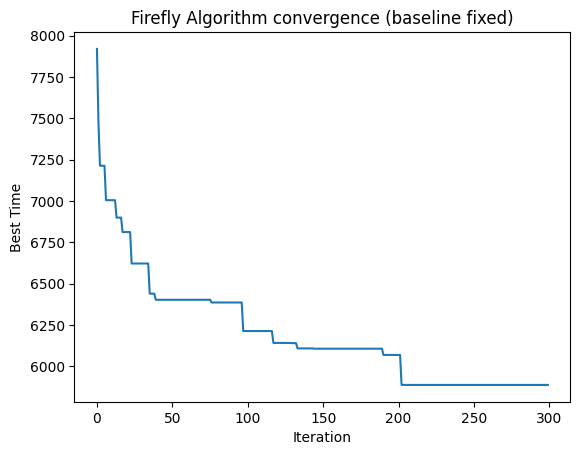

In [26]:
plt.figure()
plt.plot(history)
plt.xlabel("Iteration")
plt.ylabel("Best Time")
plt.title("Firefly Algorithm convergence (baseline fixed)")
plt.show()


 Firefly Baseline


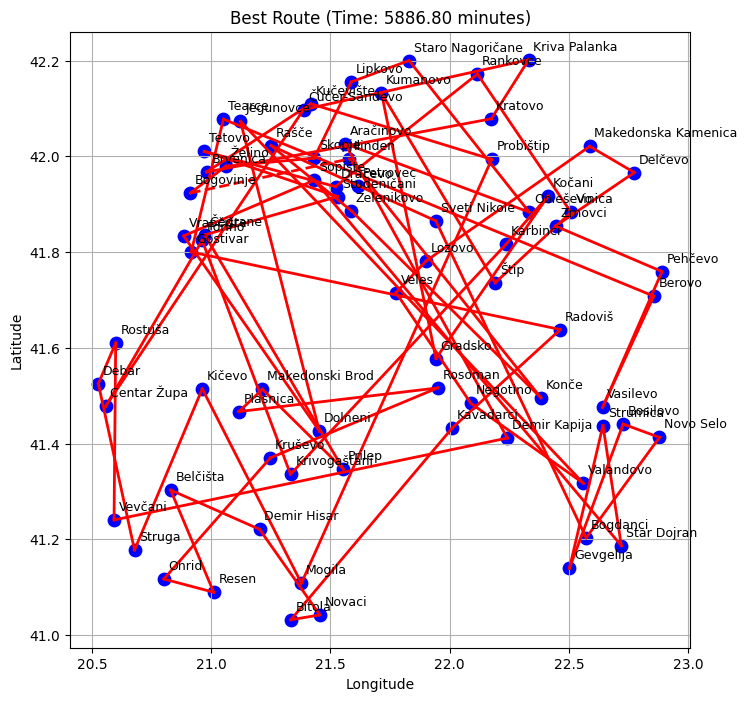

In [33]:
print("\n Firefly Baseline")
plot_route(cities_cords, best_route, best_cost)

----

# Baseline Firefly with 2-opt Local Search

In the second step, we enhance the baseline Firefly solution by applying 2-opt as a post processing local search method. While the Firefly Algorithm produces a valid route, it may still contain unnecessary crossings and suboptimal edge choices due to the discrete nature of the problem. The 2-opt procedure iteratively improves the route by reversing selected segments whenever this reduces the total travel time, continuing until no further improvement is found. This refinement significantly improves route quality and typically produces a more structured and geographically coherent tour, as reflected in the reduced total travel time and the cleaner route plot.

In [34]:
def two_opt(route, T):
    best = route.copy()
    best_cost = route_cost(best, T)
    improved = True

    while improved:
        improved = False
        for i in range(1, len(best)-2):
            for j in range(i+1, len(best)):
                if j - i == 1:
                    continue
                cand = best.copy()
                cand[i:j] = reversed(cand[i:j])
                cand_cost = route_cost(cand, T)
                if cand_cost < best_cost:
                    best = cand
                    best_cost = cand_cost
                    improved = True
    return best, best_cost

In [35]:
best_route_2opt, best_cost_2opt = two_opt(best_route, time_matrix)

print("Best cost:", best_cost_2opt)
print("Best route:", best_route_2opt)

Best cost: 2040.1999999999998
Best route: [71, 16, 5, 57, 58, 66, 65, 69, 11, 54, 0, 64, 32, 20, 72, 1, 59, 14, 53, 24, 17, 55, 10, 45, 19, 73, 18, 43, 23, 49, 47, 56, 27, 50, 8, 68, 34, 25, 41, 31, 15, 22, 37, 40, 6, 3, 42, 28, 38, 48, 46, 2, 74, 7, 63, 12, 39, 61, 13, 51, 44, 62, 30, 21, 9, 29, 35, 26, 4, 33, 52, 36, 67, 60, 70]



 Firefly Baseline with 2-opt


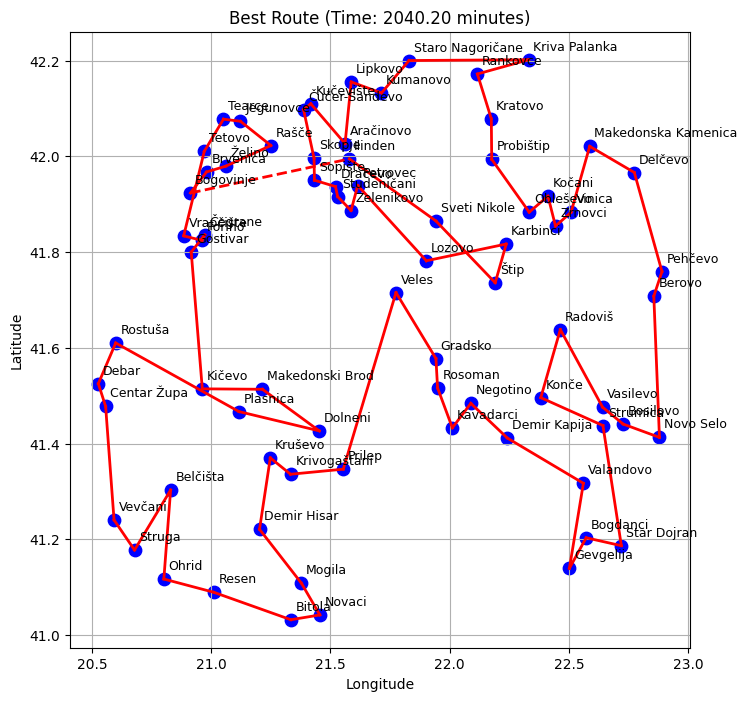

In [36]:
print("\n Firefly Baseline with 2-opt")

plot_route(cities_cords, best_route_2opt, best_cost_2opt)

# Parameter Tuning 

In this final approach, the previously introduced Firefly with 2-opt hybrid model is further refined through a grid search over key algorithm parameters. The search explores different values for population size, attraction strength, light absorption coefficient, and exploration rate, while keeping the number of iterations fixed. For each parameter combination, the Firefly algorithm is executed followed by a 2-opt local improvement step, and the resulting travel time is recorded. This systematic tuning allows the identification of a parameter configuration that yields the best performing solution, leading to an additional reduction in total travel time compared to the untuned hybrid model.

In [37]:
def run_firefly_plus_2opt(time_matrix, n_fireflies, max_iter, beta0, gamma, alpha0, seed=0):
    r, c, h = firefly_algorithm(
        time_matrix,
        n_fireflies=n_fireflies,
        max_iter=max_iter,
        beta0=beta0,
        gamma=gamma,
        alpha0=alpha0,
        seed=seed
    )
    r2, c2 = two_opt(r, time_matrix) 
    return r2, c2, h

In [39]:
grid_n_fireflies = [25,40]
grid_beta0       = [0.8,1.0]
grid_gamma       = [1.0,2.0,4.0]
grid_alpha0      = [0.2,0.4,0.6]
grid_max_iter    = [300]

seed_fixed = 0 

rows = []
best_cfg = None
best_cost = float("inf")
best_route = None

for nf in grid_n_fireflies:
    for b0 in grid_beta0:
        for g in grid_gamma:
            for a0 in grid_alpha0:
                for it in grid_max_iter:
                    r2, c2, _ = run_firefly_plus_2opt(
                        time_matrix,
                        n_fireflies=nf,
                        max_iter=it,
                        beta0=b0,
                        gamma=g,
                        alpha0=a0,
                        seed=seed_fixed
                    )

                    rows.append({
                        "n_fireflies": nf,
                        "beta0": b0,
                        "gamma": g,
                        "alpha0": a0,
                        "max_iter": it,
                        "cost_firefly_plus_2opt": float(c2)
                    })

                    if c2 < best_cost:
                        best_cost = float(c2)
                        best_route = r2
                        best_cfg = (nf, b0, g, a0, it)

grid_ff2_df = pd.DataFrame(rows).sort_values("cost_firefly_plus_2opt").reset_index(drop=True)

print("Best config (nf, beta0, gamma, alpha0, it):", best_cfg)
print("Best cost (Firefly with 2opt):", best_cost)

Best config (nf, beta0, gamma, alpha0, it): (40, 0.8, 1.0, 0.2, 300)
Best cost (Firefly with 2opt): 1886.3000000000002


In [40]:
grid_ff2_df.head(10)

,n_fireflies,beta0,gamma,alpha0,max_iter,cost_firefly_plus_2opt
0,40,0.8,1.0,0.2,300,1886.3
1,25,1.0,2.0,0.4,300,1888.6
2,25,1.0,1.0,0.2,300,1899.0
3,40,0.8,1.0,0.6,300,1905.1
4,40,0.8,4.0,0.4,300,1911.6
5,25,0.8,1.0,0.6,300,1916.5
6,40,0.8,4.0,0.6,300,1916.6
7,25,0.8,2.0,0.4,300,1918.5
8,25,1.0,1.0,0.4,300,1931.1
9,25,1.0,1.0,0.6,300,1932.2



 Final best route (Firefly + 2 opt tuned)


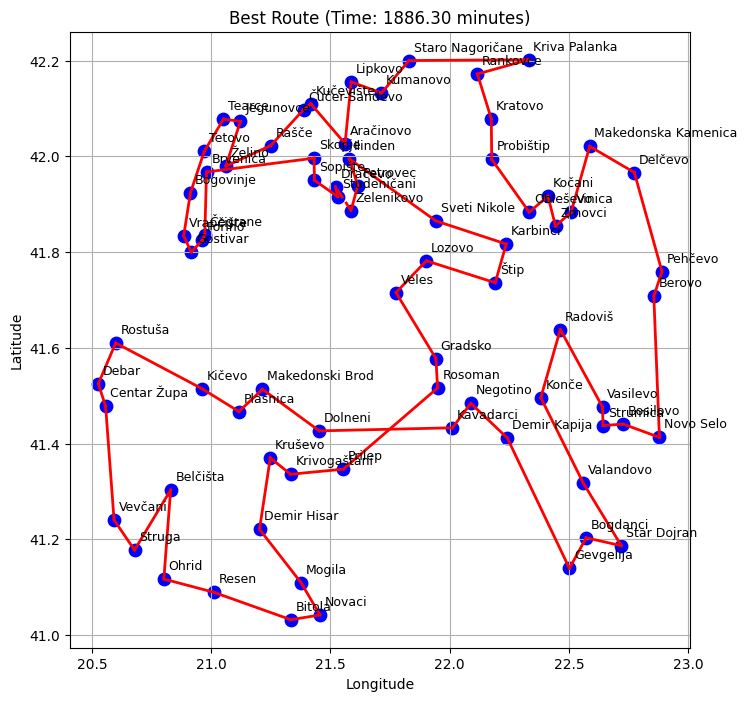

In [41]:
print("\n Final best route (Firefly + 2 opt tuned)")
plot_route(cities_cords, best_route, best_cost)